# CS 2100/4700: Introduction to Machine Learning
## Week 6 — Linear Regression Part I

### Lecture Objectives

By the end of this week, you should be able to:

1. Frame a real-world prediction task as a **machine learning problem**
2. Understand the formal setup: inputs, outputs, hypothesis, and loss
3. Derive and implement **simple and multiple linear regression**
4. Train a model using **gradient descent** and the **normal equation**
5. Evaluate regression models with appropriate metrics
6. Recognize where linear regression fits in the broader ML landscape

## Part 1: What Is a Machine Learning Problem?

Before we dive into linear regression, let's step back and formalize what it means to "do machine learning."

### 1.1 The Traditional Programming vs. ML Paradigm

| Traditional Programming | Machine Learning |
|------------------------|------------------|
| Human writes explicit rules | Algorithm **learns** rules from data |
| Input: data + rules → Output | Input: data + desired output → **Model (rules)** |
| Brittle to new situations | Can generalize to unseen data |

**Example:** Suppose you want to predict the price of a house.

- **Traditional approach:** An expert writes a formula: *price = \$100 × sqft + \$50,000*. But this breaks when the market shifts, or when location matters, or when the house has a pool.
- **ML approach:** You collect thousands of (features, price) examples and let the algorithm discover the relationship.
### 1.2 Formal Setup of a Supervised Learning Problem

Machine learning (specifically supervised learning) can be described with precise notation:

| Symbol | Meaning |
|--------|---------|
| $\mathcal{D} = \{(\mathbf{x}^{(i)}, y^{(i)})\}_{i=1}^{n}$ | **Training set** — $n$ examples |
| $\mathbf{x}^{(i)} \in \mathbb{R}^d$ | **Feature vector** (input) for example $i$, with $d$ features |
| $y^{(i)} \in \mathbb{R}$ | **Target** (output) for example $i$ |
| $f: \mathbb{R}^d \to \mathbb{R}$ | **Hypothesis function** — what we want to learn |
| $\hat{y}^{(i)} = f(\mathbf{x}^{(i)})$ | **Prediction** for example $i$ |
| $\mathcal{L}(y, \hat{y})$ | **Loss function** — measures how wrong a single prediction is |
| $J(\theta)$ | **Cost function** — average loss over the entire training set |

**The ML Goal:** Find parameters $\theta$ that minimize the cost function $J(\theta)$ over the training data, while also performing well on *unseen* data (generalization).

$$\theta^* = \arg\min_{\theta} J(\theta)$$

This is the core of what every supervised ML algorithm is trying to do — we just vary the **hypothesis class** (linear, tree, neural network, ...) and the **loss function** (squared error, cross-entropy, ...).

Supervised learning splits into two major problem types:

| Problem Type | Output ($y$) | Example |
|:---|:---|:---|
| **Regression** | Continuous number | Predict house price: \$285,000 |
| **Classification** | Discrete category | Predict spam or not spam |

**Today's focus:** We tackle our very first machine learning algorithm — **Linear Regression** — the most fundamental algorithm for regression problems.

### Why Start with Linear Regression?

- It's the simplest ML algorithm, yet remarkably powerful
- It introduces **every key concept** you'll reuse in more complex models:
  - Hypothesis function, cost function, optimization, evaluation
- Many advanced algorithms (logistic regression, neural networks) are *extensions* of linear regression
## Part 2: Linear Regression — Our First ML Algorithm

### A Motivating Example: Predicting House Prices

Imagine you're a real-estate agent. You have historical data on houses that sold recently. Can you predict the price of a new house based on its size?

Let's look at some data:


In [2]:
import numpy as np

# Our "training data" — houses that already sold
sizes = np.array([600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2500, 2800, 3000])
prices = np.array([150, 180, 210, 245, 270, 305, 340, 360, 400, 430, 475, 510])

# Display as a nice table
print("House Sales Data")
print("=" * 35)
print(f"{'Size (sq ft)':>14}  {'Price ($1000s)':>14}")
print("-" * 35)
for s, p in zip(sizes, prices):
    print(f"{s:>14,}  {p:>14}")
print("=" * 35)
print(f"\n {len(sizes)} training examples")

House Sales Data
  Size (sq ft)  Price ($1000s)
-----------------------------------
           600             150
           800             180
         1,000             210
         1,200             245
         1,400             270
         1,600             305
         1,800             340
         2,000             360
         2,200             400
         2,500             430
         2,800             475
         3,000             510

 12 training examples


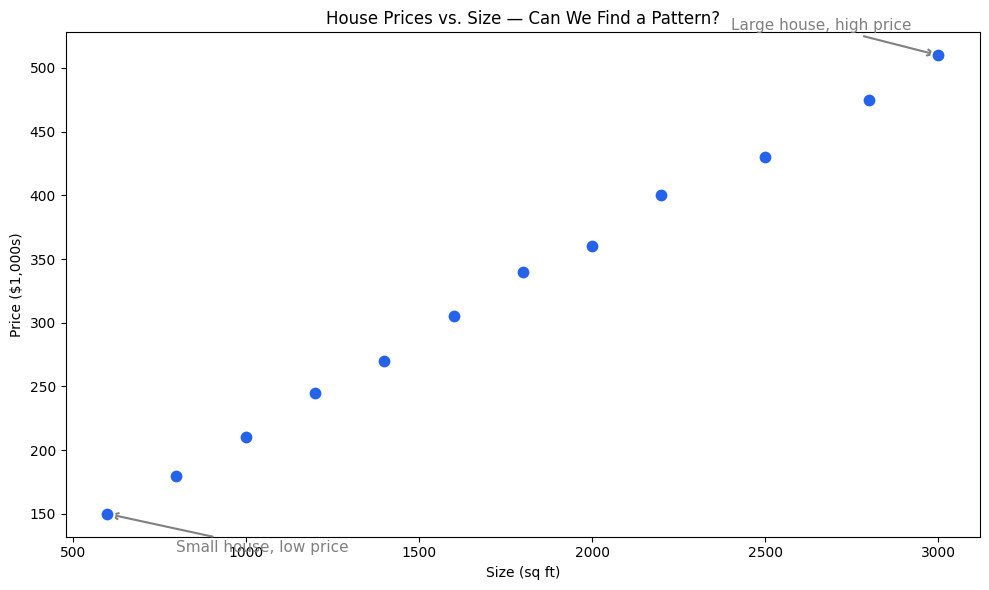

In [3]:
import matplotlib.pyplot as plt
# Scatter plot of the raw data
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(sizes, prices, s=100, c='#2563EB', edgecolors='white', linewidths=1.5, zorder=5)

# Annotate a couple of points
ax.annotate('Small house, low price', xy=(600, 150), xytext=(800, 120),
            fontsize=11, color='gray',
            arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))
ax.annotate('Large house, high price', xy=(3000, 510), xytext=(2400, 530),
            fontsize=11, color='gray',
            arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

ax.set_xlabel('Size (sq ft)')
ax.set_ylabel('Price ($1,000s)')
ax.set_title('House Prices vs. Size — Can We Find a Pattern?')
plt.tight_layout()
plt.show()

**The question:** Can we draw a line through this data that lets us predict the price of a *new* house we've never seen before?

That's exactly what Linear Regression does. Let's formalize this.

---

## Part 2: The Hypothesis Function

### What Is a "Hypothesis"?

In ML, a **hypothesis** $h(x)$ is the function our model uses to make predictions. The goal of learning is to find the hypothesis that best maps inputs to outputs.

For linear regression, our hypothesis is a **linear function**:

$$\boxed{h(x) = \theta_0 + \theta_1 x}$$

| Symbol | Name | Meaning |
|:---:|:---|:---|
| $h(x)$ | Hypothesis | Our model's prediction for input $x$ |
| $\theta_0$ | Intercept (bias) | Where the line crosses the y-axis |
| $\theta_1$ | Slope (weight) | How much $y$ changes per unit change in $x$ |
| $x$ | Feature | The input variable (e.g., house size) |

> **Key Insight:** The algorithm's entire job is to find the *best* values for $\theta_0$ and $\theta_1$. These are called **parameters** (also known as **weights** or **coefficients**).

### Visual Intuition: What Do the Parameters Control?

Let's see how changing $\theta_0$ and $\theta_1$ changes the line:

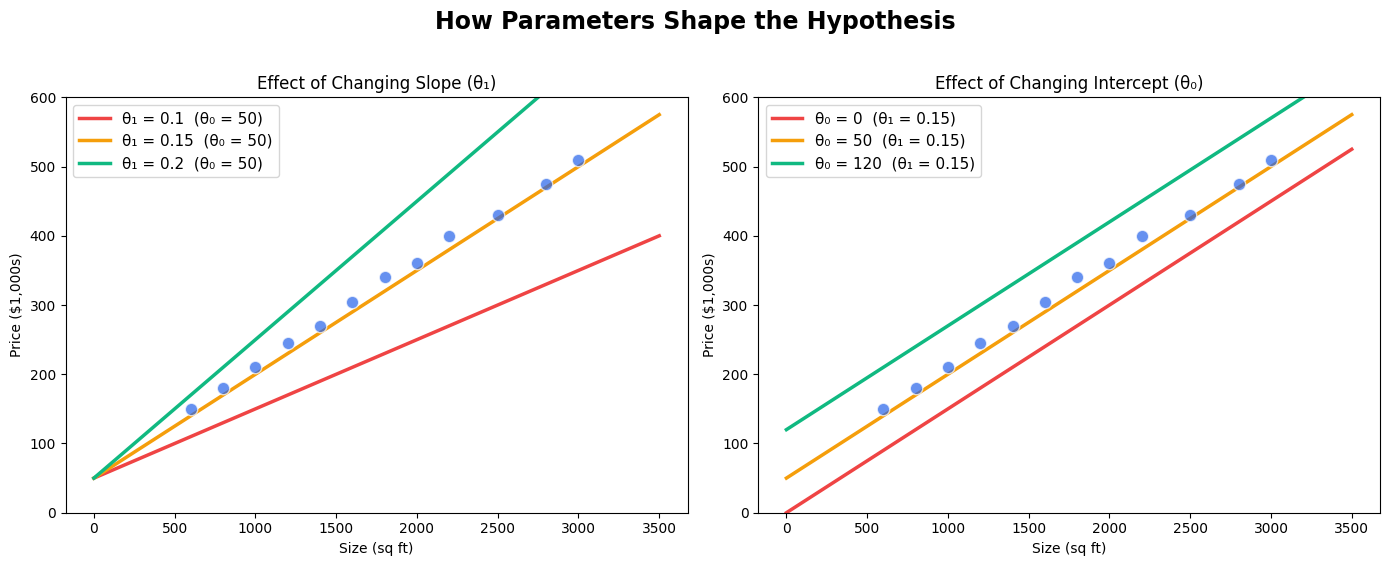

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

x_range = np.linspace(0, 3500, 100)

# --- Left panel: varying slope (theta_1) ---
ax = axes[0]
ax.scatter(sizes, prices, s=80, c='#2563EB', edgecolors='white', linewidths=1, zorder=5, alpha=0.7)
slopes = [0.10, 0.15, 0.20]
colors_slope = ['#EF4444', '#F59E0B', '#10B981']
for slope, color in zip(slopes, colors_slope):
    y_line = 50 + slope * x_range
    ax.plot(x_range, y_line, color=color, label=f'θ₁ = {slope}  (θ₀ = 50)', linewidth=2.5)
ax.set_xlabel('Size (sq ft)')
ax.set_ylabel('Price ($1,000s)')
ax.set_title('Effect of Changing Slope (θ₁)')
ax.legend(fontsize=11)
ax.set_ylim(0, 600)

# --- Right panel: varying intercept (theta_0) ---
ax = axes[1]
ax.scatter(sizes, prices, s=80, c='#2563EB', edgecolors='white', linewidths=1, zorder=5, alpha=0.7)
intercepts = [0, 50, 120]
colors_int = ['#EF4444', '#F59E0B', '#10B981']
for inter, color in zip(intercepts, colors_int):
    y_line = inter + 0.15 * x_range
    ax.plot(x_range, y_line, color=color, label=f'θ₀ = {inter}  (θ₁ = 0.15)', linewidth=2.5)
ax.set_xlabel('Size (sq ft)')
ax.set_ylabel('Price ($1,000s)')
ax.set_title('Effect of Changing Intercept (θ₀)')
ax.legend(fontsize=11)
ax.set_ylim(0, 600)

plt.suptitle('How Parameters Shape the Hypothesis', fontsize=17, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Takeaway:**
- $\theta_1$ (slope) controls the **steepness** — how sensitive the prediction is to changes in $x$
- $\theta_0$ (intercept) controls the **vertical shift** — the baseline prediction when $x = 0$

### Simple vs. Multiple Linear Regression

| Type | Formula | # of Features |
|:---|:---|:---:|
| **Simple** Linear Regression | $h(x) = \theta_0 + \theta_1 x$ | 1 |
| **Multiple** Linear Regression | $h(\mathbf{x}) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 + \cdots + \theta_n x_n$ | $n$ |

In **vector notation**, multiple linear regression is elegantly written as:

$$h(\mathbf{x}) = \boldsymbol{\theta}^T \mathbf{x}$$

where $\boldsymbol{\theta} = [\theta_0, \theta_1, \ldots, \theta_n]^T$ and $\mathbf{x} = [1, x_1, \ldots, x_n]^T$ (the 1 is for the intercept term).

We'll use simple linear regression today for clarity, but everything generalizes to multiple features.

---

## Part 3: The Cost Function — Defining "Best"

### The Central Question

We have many possible lines. **Which one is "best"?**

We need a way to measure how *wrong* our model is. That measure is called a **cost function** (or **loss function**).

### Step-by-Step: Building the Mean Squared Error (MSE)

Let's build intuition for *why* MSE is the standard cost function for regression.

**Step 1: Define "Error" for one prediction**

The error (or **residual**) for a single training example $i$ is:

$$\text{error}^{(i)} = h(x^{(i)}) - y^{(i)}$$

This is just the vertical distance between our prediction and the actual value.

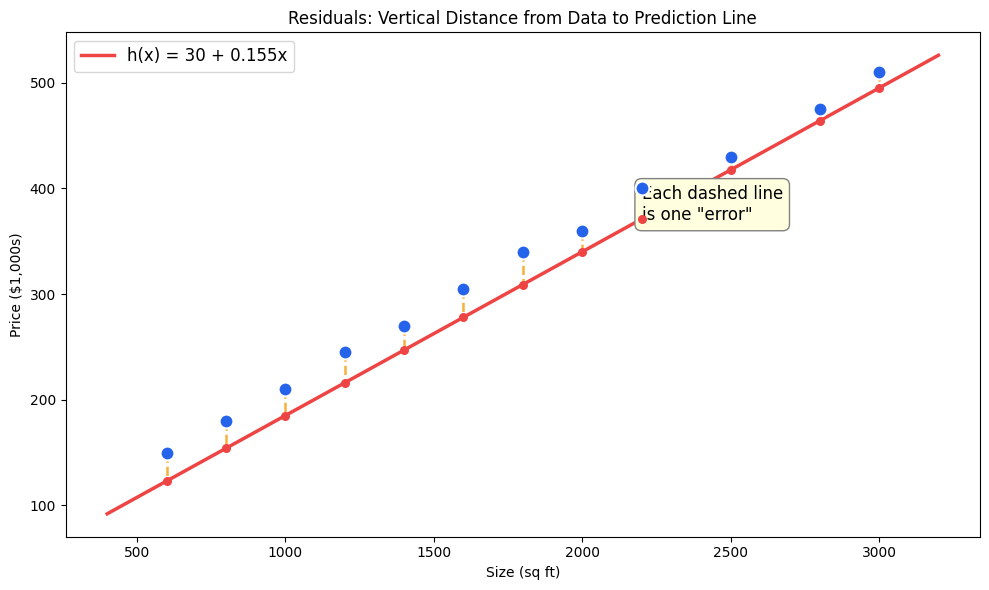

In [5]:
# Visualize residuals (errors) for a specific line
theta_0_demo, theta_1_demo = 30, 0.155

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(sizes, prices, s=100, c='#2563EB', edgecolors='white', linewidths=1.5, zorder=5)

# The hypothesis line
x_line = np.linspace(400, 3200, 100)
y_line = theta_0_demo + theta_1_demo * x_line
ax.plot(x_line, y_line, color='#EF4444', linewidth=2.5, label=f'h(x) = {theta_0_demo} + {theta_1_demo}x')

# Draw residual lines
for s, p in zip(sizes, prices):
    predicted = theta_0_demo + theta_1_demo * s
    color = '#10B981' if predicted >= p else '#F59E0B'
    ax.plot([s, s], [p, predicted], color=color, linewidth=1.8, linestyle='--', alpha=0.8)
    # Small markers at the prediction points
    ax.scatter(s, predicted, color='#EF4444', s=30, zorder=6)

ax.set_xlabel('Size (sq ft)')
ax.set_ylabel('Price ($1,000s)')
ax.set_title('Residuals: Vertical Distance from Data to Prediction Line')
ax.legend(fontsize=12, loc='upper left')

# Add annotation
ax.annotate('Each dashed line\nis one "error"', xy=(2200, 370), fontsize=12,
            bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', edgecolor='gray'))

plt.tight_layout()
plt.show()

**Step 2: Why square the errors?**

Raw errors can be positive or negative — they'd cancel out if we just summed them! Squaring solves this and also **penalizes larger errors more heavily** (a desirable property).

| Raw Error | Squared Error |
|:---:|:---:|
| +2 | 4 |
| -3 | 9 |
| +10 | **100** ← large errors get amplified! |

**Step 3: Average over all training examples**

The **Mean Squared Error** cost function:

$$\boxed{J(\theta_0, \theta_1) = \frac{1}{2m} \sum_{i=1}^{m} \left( h(x^{(i)}) - y^{(i)} \right)^2}$$

| Symbol | Meaning |
|:---:|:---|
| $m$ | Number of training examples |
| $h(x^{(i)})$ | Model's prediction for the $i$-th example |
| $y^{(i)}$ | Actual value for the $i$-th example |
| $\frac{1}{2}$ | Convention — makes the derivative cleaner (you'll see why shortly) |

> **Intuition:** $J(\theta)$ is a single number that summarizes how badly our model fits the data. **Lower is better.**

In [6]:
def compute_cost(X, y, theta_0, theta_1):
    """Compute the MSE cost function J(theta_0, theta_1)."""
    m = len(y)
    predictions = theta_0 + theta_1 * X
    errors = predictions - y
    cost = (1 / (2 * m)) * np.sum(errors ** 2)
    return cost

# Compare a "good" line vs. a "bad" line
cost_good = compute_cost(sizes, prices, 30, 0.155)
cost_bad  = compute_cost(sizes, prices, 300, 0.05)

print("Cost Function Comparison")
print("=" * 50)
print(f"  'Good' line  (θ₀=30,  θ₁=0.155): J = {cost_good:.2f}")
print(f"  'Bad' line   (θ₀=300, θ₁=0.05) : J = {cost_bad:.2f}")
print(f"\n  The 'good' line has {cost_bad/cost_good:.1f}× lower cost ✅")

Cost Function Comparison
  'Good' line  (θ₀=30,  θ₁=0.155): J = 284.72
  'Bad' line   (θ₀=300, θ₁=0.05) : J = 4812.50

  The 'good' line has 16.9× lower cost ✅


### Visualizing the Cost Function Landscape

What does $J(\theta_0, \theta_1)$ look like if we plot it for *all possible* parameter values?

For simple linear regression with MSE, the cost surface is always a **smooth, bowl-shaped** surface (a convex paraboloid). This is great news — it means there's exactly **one minimum**, and we can always find it!

In [ ]:
# 3D surface plot of the cost function
from mpl_toolkits.mplot3d import Axes3D

theta0_range = np.linspace(-100, 200, 120)
theta1_range = np.linspace(-0.05, 0.35, 120)
T0, T1 = np.meshgrid(theta0_range, theta1_range)

# Compute cost for every (theta0, theta1) combo
J = np.zeros_like(T0)
for i in range(T0.shape[0]):
    for j in range(T0.shape[1]):
        J[i, j] = compute_cost(sizes, prices, T0[i, j], T1[i, j])

fig = plt.figure(figsize=(14, 5.5))

# --- 3D Surface ---
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(T0, T1, J, cmap='coolwarm', alpha=0.85, edgecolor='none')
ax1.set_xlabel('θ₀ (intercept)')
ax1.set_ylabel('θ₁ (slope)')
ax1.set_zlabel('J(θ₀, θ₁)')
ax1.set_title('Cost Function Surface')
ax1.view_init(elev=30, azim=-120)

# Mark the minimum
min_idx = np.unravel_index(np.argmin(J), J.shape)
ax1.scatter(T0[min_idx], T1[min_idx], J[min_idx], color='gold', s=200, marker='*', zorder=10)

# --- Contour Plot ---
ax2 = fig.add_subplot(122)
contour = ax2.contour(T0, T1, J, levels=30, cmap='coolwarm')
ax2.clabel(contour, inline=True, fontsize=8)
ax2.plot(T0[min_idx], T1[min_idx], 'g*', markersize=20, label='Minimum')
ax2.set_xlabel('θ₀ (intercept)')
ax2.set_ylabel('θ₁ (slope)')
ax2.set_title('Contour Plot (Top-Down View)')
ax2.legend(fontsize=12)

plt.suptitle('The MSE Cost Landscape Is a Smooth Bowl — One Global Minimum', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Key Observation:** The cost surface is a smooth **convex** bowl. The star marks the minimum — the best $\theta_0, \theta_1$ values. The contour plot on the right shows the same landscape from above (like a topographic map).

---

## Part 4: Finding the Best Parameters

We know *what* we want to minimize ($J$). Now: **how** do we find the $\theta$ values that minimize it?

Two approaches:

### Approach 1: The Normal Equation (Closed-Form Solution)

For linear regression, we can solve for the optimal weights analytically. Using matrix notation where $\mathbf{X}$ is the $n \times (d+1)$ design matrix and $\mathbf{y}$ is the $n \times 1$ target vector:

$$\mathbf{w}^* = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}$$

**Derivation sketch:**
1. Write the cost in matrix form: $J(\mathbf{w}) = \frac{1}{n}(\mathbf{X}\mathbf{w} - \mathbf{y})^\top(\mathbf{X}\mathbf{w} - \mathbf{y})$
2. Take the gradient: $\nabla_{\mathbf{w}} J = \frac{2}{n}\mathbf{X}^\top(\mathbf{X}\mathbf{w} - \mathbf{y})$
3. Set to zero and solve: $\mathbf{X}^\top \mathbf{X} \mathbf{w} = \mathbf{X}^\top \mathbf{y}$

- **Pros:** Exact solution, no hyperparameters. 
- **Cons:** Requires inverting a $(d+1) \times (d+1)$ matrix — $O(d^3)$ complexity. Impractical when $d$ is very large.

In [7]:
# Normal Equation implementation
def normal_equation(X, y):
    """Compute optimal theta using the Normal Equation."""
    # Add column of 1s for the intercept (bias) term
    X_b = np.column_stack([np.ones(len(X)), X])
    # Apply the formula: theta = (X^T X)^(-1) X^T y
    theta = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y
    return theta

theta_normal = normal_equation(sizes, prices)
print("Normal Equation Solution")
print("=" * 40)
print(f"  θ₀ (intercept) = {theta_normal[0]:.4f}")
print(f"  θ₁ (slope)     = {theta_normal[1]:.6f}")
print(f"\n  Interpretation: For every additional sq ft,")
print(f"  the predicted price increases by ${theta_normal[1]*1000:.2f}")

Normal Equation Solution
  θ₀ (intercept) = 63.5647
  θ₁ (slope)     = 0.148910

  Interpretation: For every additional sq ft,
  the predicted price increases by $148.91


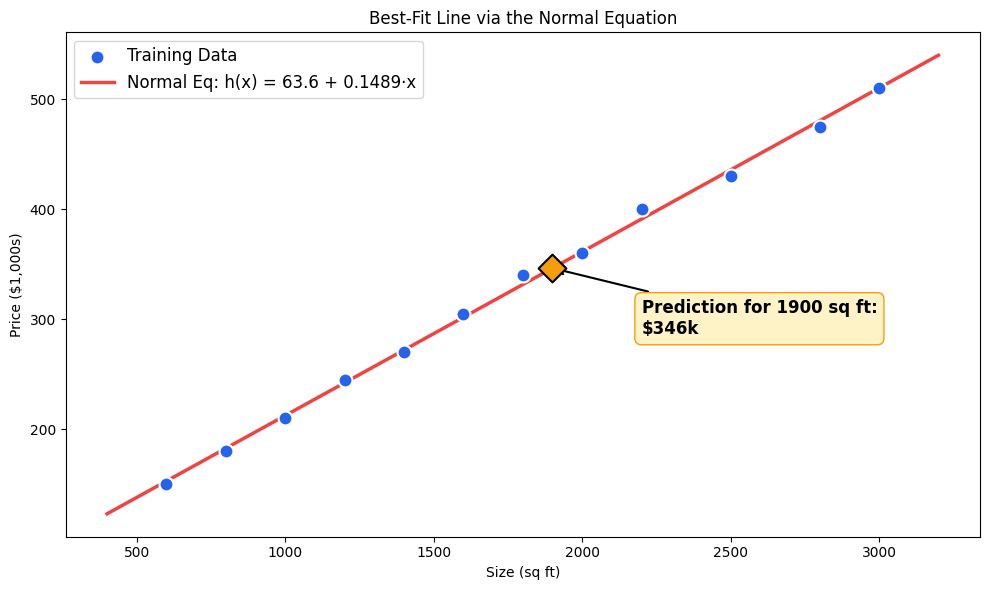

In [8]:
# Plot the Normal Equation solution
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(sizes, prices, s=100, c='#2563EB', edgecolors='white', linewidths=1.5, zorder=5, label='Training Data')

x_plot = np.linspace(400, 3200, 100)
y_plot = theta_normal[0] + theta_normal[1] * x_plot
ax.plot(x_plot, y_plot, color='#EF4444', linewidth=2.5, label=f'Normal Eq: h(x) = {theta_normal[0]:.1f} + {theta_normal[1]:.4f}·x')

# Show a prediction for a new house
new_size = 1900
new_pred = theta_normal[0] + theta_normal[1] * new_size
ax.scatter(new_size, new_pred, s=200, color='#F59E0B', marker='D', edgecolors='black', linewidths=1.5, zorder=6)
ax.annotate(f'Prediction for {new_size} sq ft:\n${new_pred:.0f}k',
            xy=(new_size, new_pred), xytext=(new_size+300, new_pred-60),
            fontsize=12, fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='black', lw=1.5),
            bbox=dict(boxstyle='round,pad=0.4', facecolor='#FEF3C7', edgecolor='#F59E0B'))

ax.set_xlabel('Size (sq ft)')
ax.set_ylabel('Price ($1,000s)')
ax.set_title('Best-Fit Line via the Normal Equation')
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Approach 2: Gradient Descent (Iterative / Numerical Solution)

The Normal Equation is elegant, but it **doesn't generalize** to other ML algorithms. We need a more universal approach.

**Gradient Descent** is *the* workhorse optimization algorithm in machine learning. It works for linear regression, logistic regression, neural networks, and nearly every other model.

#### The Analogy: Walking Down a Hill Blindfolded 🏔️

Imagine you're standing somewhere on the cost function surface (the bowl from earlier), **blindfolded**:

1. **Feel the slope** beneath your feet (compute the **gradient** — a vector of partial derivatives)
2. **Take a step downhill** in the steepest direction
3. **Repeat** until you reach the bottom (the minimum)

#### The Algorithm

Repeat until convergence:

$$\theta_0 := \theta_0 - \alpha \cdot \frac{1}{m} \sum_{i=1}^{m} \left( h(x^{(i)}) - y^{(i)} \right)$$

$$\theta_1 := \theta_1 - \alpha \cdot \frac{1}{m} \sum_{i=1}^{m} \left( h(x^{(i)}) - y^{(i)} \right) \cdot x^{(i)}$$

| Symbol | Meaning |
|:---:|:---|
| $\alpha$ | **Learning rate** — the step size |
| $\frac{\partial J}{\partial \theta}$ | The gradient — tells us the direction and steepness |
| $:=$ | "Update" — replace the old value with the new one |

> **Important:** Both $\theta_0$ and $\theta_1$ must be updated **simultaneously** (compute both updates, *then* apply both).

In [ ]:
def gradient_descent(X, y, theta_0, theta_1, alpha, n_iterations):
    """
    Run gradient descent to learn theta_0 and theta_1.
    Returns the final parameters AND the history for visualization.
    """
    m = len(y)
    cost_history = []
    theta0_history = [theta_0]
    theta1_history = [theta_1]
    
    for i in range(n_iterations):
        # Predictions with current parameters
        predictions = theta_0 + theta_1 * X
        errors = predictions - y
        
        # Compute gradients
        grad_theta0 = (1 / m) * np.sum(errors)
        grad_theta1 = (1 / m) * np.sum(errors * X)
        
        # Simultaneous update
        theta_0 = theta_0 - alpha * grad_theta0
        theta_1 = theta_1 - alpha * grad_theta1
        
        # Record history
        cost = (1 / (2 * m)) * np.sum(errors ** 2)
        cost_history.append(cost)
        theta0_history.append(theta_0)
        theta1_history.append(theta_1)
    
    return theta_0, theta_1, cost_history, theta0_history, theta1_history

# Run gradient descent
# Note: we normalize features for better convergence (more on this later)
sizes_norm = (sizes - sizes.mean()) / sizes.std()
prices_norm = prices  # keep prices in original scale for interpretability

theta_0_gd, theta_1_gd, costs, t0_hist, t1_hist = gradient_descent(
    sizes_norm, prices_norm, 
    theta_0=0, theta_1=0,  # start from zero
    alpha=0.1, 
    n_iterations=100
)

print("Gradient Descent Solution (after 100 iterations)")
print("=" * 50)
print(f"  θ₀ = {theta_0_gd:.4f},  θ₁ = {theta_1_gd:.4f}")
print(f"  Final cost J = {costs[-1]:.4f}")
print(f"\n  (Parameters are in the normalized feature space)")

In [ ]:
# Visualize gradient descent convergence
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# --- Left: Cost over iterations ---
ax = axes[0]
ax.plot(costs, color='#EF4444', linewidth=2.5)
ax.set_xlabel('Iteration')
ax.set_ylabel('Cost J(θ)')
ax.set_title('Cost Function Decreases Over Iterations')
ax.axhline(y=costs[-1], color='gray', linestyle='--', alpha=0.5)
ax.annotate(f'Converged: J = {costs[-1]:.2f}', xy=(80, costs[-1]),
            fontsize=12, color='gray')

# --- Right: Path on the contour plot ---
ax = axes[1]
# Recompute cost surface in normalized space
t0_range = np.linspace(min(t0_hist)-50, max(t0_hist)+50, 100)
t1_range = np.linspace(min(t1_hist)-50, max(t1_hist)+50, 100)
T0g, T1g = np.meshgrid(t0_range, t1_range)
Jg = np.zeros_like(T0g)
for i in range(T0g.shape[0]):
    for j in range(T0g.shape[1]):
        Jg[i, j] = compute_cost(sizes_norm, prices_norm, T0g[i, j], T1g[i, j])

contour = ax.contour(T0g, T1g, Jg, levels=25, cmap='coolwarm', alpha=0.7)
# Plot the path
ax.plot(t0_hist, t1_hist, 'o-', color='#10B981', markersize=4, linewidth=1.5, label='GD Path')
ax.plot(t0_hist[0], t1_hist[0], 's', color='#F59E0B', markersize=14, zorder=10, label='Start')
ax.plot(t0_hist[-1], t1_hist[-1], '*', color='#EF4444', markersize=18, zorder=10, label='End (≈ Minimum)')
ax.set_xlabel('θ₀')
ax.set_ylabel('θ₁')
ax.set_title('Gradient Descent Path on Cost Contour')
ax.legend(fontsize=11)

plt.suptitle('Gradient Descent in Action', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### The Learning Rate ($\alpha$): The Most Important Hyperparameter

The learning rate controls the **step size**. Getting it right is crucial:

In [ ]:
# Show the effect of different learning rates
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
alphas = [0.001, 0.1, 0.5]
titles = ['α = 0.001 (Too Small)', 'α = 0.1 (Just Right)', 'α = 0.5 (Too Large — Diverges!)']
colors = ['#EF4444', '#10B981', '#7C3AED']

for ax, alpha, title, color in zip(axes, alphas, titles, colors):
    try:
        _, _, cost_hist, _, _ = gradient_descent(
            sizes_norm, prices_norm, 0, 0, alpha, 50
        )
        ax.plot(cost_hist, color=color, linewidth=2.5)
        ax.set_ylim(0, max(cost_hist[0]*1.2, costs[0]*2))
    except:
        ax.text(0.5, 0.5, 'Diverged!', transform=ax.transAxes, 
                fontsize=18, ha='center', va='center', color='red')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Cost J(θ)')
    ax.set_title(title, fontsize=13)

plt.suptitle('Effect of Learning Rate on Convergence', fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

**Guidelines for choosing $\alpha$:**
- Start with a small value (e.g., 0.01 or 0.001) and increase gradually
- If cost is decreasing slowly → try a larger $\alpha$
- If cost is oscillating or increasing → $\alpha$ is too large, reduce it
- Common choices: 0.001, 0.003, 0.01, 0.03, 0.1, 0.3

### Normal Equation vs. Gradient Descent: When to Use Which?

| | Normal Equation | Gradient Descent |
|:---|:---|:---|
| **Speed** | Fast for small $n$ | Scales well to large $n$ |
| **Iteration** | No iteration needed | Iterative (must choose # of iterations) |
| **Hyperparameters** | None | Must choose learning rate $\alpha$ |
| **Feature Scaling** | Not needed | Works much better with scaling |
| **Generality** | Linear regression only | Works with any differentiable cost function |
| **Practical Rule** | Use when $n < 10,000$ | Use when $n$ is large or for other algorithms |

---

## Part 5: Putting It All Together

### The Complete ML Pipeline (So Far)

Let's trace through the full process one more time:

```
1. COLLECT DATA        →  (x, y) pairs
2. DEFINE THE MODEL    →  h(x) = θ₀ + θ₁x  (hypothesis)
3. DEFINE THE COST     →  J(θ) = MSE  (how to measure error)
4. OPTIMIZE            →  Gradient Descent or Normal Eq.  (find best θ)
5. PREDICT             →  Use the learned h(x) on new data
```

This 5-step framework applies to **every** supervised learning algorithm we'll study this semester. The only things that change are the hypothesis function and sometimes the cost function.

In [ ]:
# Final demo: the complete pipeline in ~15 lines of code
print("=" * 60)
print("  THE COMPLETE LINEAR REGRESSION PIPELINE")
print("=" * 60)

# Step 1: Data (already have sizes and prices)
print("\n📦 Step 1: Data → 12 training examples")

# Step 2: Model
print("📐 Step 2: Model → h(x) = θ₀ + θ₁·x")

# Step 3: Cost function
print("📉 Step 3: Cost → J(θ) = (1/2m) Σ(h(x) - y)²")

# Step 4: Optimize
theta = normal_equation(sizes, prices)
print(f"⚙️  Step 4: Optimize → θ₀ = {theta[0]:.2f}, θ₁ = {theta[1]:.4f}")

# Step 5: Predict!
new_houses = [1500, 2000, 2500, 3500]
print(f"\n🔮 Step 5: Predict!")
print("-" * 40)
for house in new_houses:
    pred = theta[0] + theta[1] * house
    print(f"  {house:>5} sq ft  →  ${pred:>7.1f}k")

print("\n✅ That's it — you just built your first ML model!")